# MNIST dataset training
The algorithms is taken from [3B1B](https://youtu.be/aircAruvnKk)

The TS library is used only to download the dataset

### Libs and dataset loading

In [2]:
# Typing
from typing import Callable, Union
import numpy.typing as npt

# Structure
from dataclasses import dataclass
from enum import Enum

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rnd

c:\user\projects\python\LearningML\NoLibImpl\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Downloading the dataset
dataset = load_dataset("mnist")

Reusing dataset mnist (C:\Users\mario\.cache\huggingface\datasets\mnist\mnist\1.0.0\fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)
100%|██████████| 2/2 [00:00<00:00, 333.62it/s]


In [4]:
# Converting the dataset obj to the pd.DataFrame (to make the work easier)
_train, _test = dataset.values()
ds_train = pd.DataFrame(_train)
ds_test = pd.DataFrame(_test)

ds_train.head()

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,5
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,4
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,1
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,9


### Creating data preparation pipeline

In [5]:
def preparation_pipeline(ds: pd.DataFrame) -> None:
    # (PillowPNG -> np.array) => normalizing (unint8 -> float32) => flattening input
    ds["image"] = ds["image"].apply(lambda el: np.array(el).reshape((-1,)) / 255.)
    # Hot-encoding output
    ds["label"] = ds["label"].apply(lambda el: 1. * (np.arange(10) == el))
    # Renaming the columns
    ds.rename({"image": "x", "label": "y"}, inplace=True)


# Applying pipeline
for ds in [ds_train, ds_test]:
    preparation_pipeline(ds)

# Shuffling with pd method sample
ds_train = ds_train.sample(frac=1).reset_index(drop=True)

ds_train.iloc[0]["image"].shape

(784,)

## Recurrent formulas:
### Some reference
<img src="./images/ref1.png" width="700"/>

The recurent formulas are the initial bounds of our model, which we are then using to derive the training steps.

Basically, we could define our model as $ F(x) = y $, but, as it must be more complex than this, we make some expansion.

As we are dealing with the neural network, it is much better to store weights between two layers in a 2d matrix:
$$ \displaystyle
W^{(l)}_{m\leftarrow n} = 
\begin{pmatrix}
    w^{(l)}_{11} & w^{(l)}_{12} & \dots & w^{(l)}_{1n} \\
    w^{(l)}_{21} & w^{(l)}_{22} & \dots & w^{(l)}_{2n} \\
        \vdots & \vdots & \ddots & \vdots \\
    w^{(l)}_{m1} & w^{(l)}_{m2} & \dots & w^{(l)}_{mn} \\
\end{pmatrix},
$$
Where $ w^{(l)}_{ij} $ denotes weight from neuron $i$ to neuron $j$ in layer $l$.
Lets call this $ W^{(l)} $ -thing, which is essentially symbolices the bundle of weights between two layers, *the weights layer number $l$*.

As we are approaching matrix math, let us denote **($*$)** as a **matrix multiplication** and **($\cdot$)** as **element-wise multiplication** (and as this operation doesn't affects the dimentionality, often this dot could be just omited 🙃). Please also note, that having the element-wise multiplication gives us the right to define in the same way the **element-wise division**.

Let also $W$ would be the array, holding all of these matrixes:
$$ W = [\;\underbrace{W^{(0)}, W^{(1)}, \dots, W^{(L-2)}}_{L-1}\;] $$
<div></div>

But now lets define the neuron function and its output.
Let $raw^{(l)} = [raw^{(l)}_1, raw^{(l)}_2, \dots, raw^{(l)}_i, \dots, raw^{(l)}_n]$
would be the input, that goes to the neuron $i$ in layer $l$.
And let the $A_f^{(l)}: \mathbb{R}\rightarrow \mathbb{R}$ - an activation function of neurons in the layer $l$ and $A_d^{(l)}$ - its derivative.
Okay, now we are finally able to define the output of the neuron layer $l$ as $out^{(l)} = [out^{(l)}_1, out^{(l)}_2, \dots, out^{(l)}_i, \dots, out^{(l)}_n]$, where $out^{(l)}_i$ denotes output of $i$ -th neuron.

It is also quite a crutial thing not to mess up the indexes. And so, please note that while let we have $L$ layers of neurons, there are only $L-1$ "weighted connections" between them, thus we have only L-1 elements of $W$ array respectively. And this means that there are also $L$ inputs/outputs of the each neuron layer, which we would also store in one list, following the $W$ model:
$$ raw = [\;\underbrace{raw^{(0)}, raw^{(1)}, \dots, raw^{(L-1)}}_{L}\;] $$
$$ out = [\;\underbrace{out^{(0)}, out^{(1)}, \dots, out^{(L-1)}}_{L}\;] $$
<div></div>

Taking the things said before into account, we are finally could define the "function" $F$:
$$
F: \begin{cases}
out^{(0)} = x; \\
raw^{(l)} = W^{(l-1)} * out^{(l-1)} + b^{(l-1)}; \\
out^{(l)} = A_f^{(l)}(raw^{(l)}); \\
y = out^{(L-1)};
\end{cases}
$$
(Where $b^{(l)}$ is a bias of $l$ -th layer, and has the same dimentionality as $W^{(l)} * out^{(l-1)}$)

## Layers class

In [6]:
@dataclass
class ActivationFunction:
    """
        This class is used to store information about the activation function.
        (In our case we store the function, its derivative and name).
    """

    name: str

    # The function callable
    # (Pay close attention to the input and output types: 
    #   we are applying function elementwise)
    f: Callable[[np.ndarray], np.ndarray]

    # The derivative callable of function
    d: Callable[[np.ndarray], np.ndarray]

    # This thing would make our live easier, debugging the model
    def __str__(self):
        return self.name
    

class Functions:
    """
        Singleton thing to store existing activation functions
    """

    # Lambda notation used not to mess up too much the code
    sigmoid = ActivationFunction(
        "sigmoid()",
        lambda x: 1 / (1 + np.exp(-x)),
        # https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
        lambda x: (lambda o: o*(1-o)) (1 / (1 + np.exp(-x)))
    )

    relu = ActivationFunction(
        "relu()",
        # Attention: we are multiplying float with bool 
        # https://stackoverflow.com/questions/18601484/subtract-boolean-from-float-in-python
        lambda x: x * (x >= 0),
        lambda x: 1. * (x > 0)
    )

In [7]:
# Testing our brand-new abstractions:
str(Functions.sigmoid), Functions.sigmoid.f(0.5)

('sigmoid()', 0.6224593312018546)

## Model class

In [8]:
# FINALLY WE HAVE THE NEURAL MODEL CLASS!

class Model:
    """
        This thing would help us to build an abstraction from the arrays of arrays of arrays...
    """

    class WeightsFilling(Enum):
        """
            Enum storing available types of filling (in __init__ func) our weights
        """
        RANDOM = 0
        ZEROS = 1
        ONES = 2

    def __init__(self, 
        shape: tuple[int],
        activations: list[ActivationFunction] = list(),
        fill_type: Union[WeightsFilling, list[WeightsFilling]] = list()
    ):
        """
            :param shape: number of "neurons" is each of the network layers
                (actually will be used to specify the matrix dimentionality)
            
            :param activations: activations that are used in each network layer

            :param fill_type: types of filling for each of the "weights layers"
                (bundle of weights inbetween layers)
        """

        self.shape = shape
        self.L = len(shape)

        # Formatting activation parameter
        if not activations:
            activations = np.full(self.L - 1, Functions.sigmoid)
        else:
            activations = np.array(activations)
        
        # Formatting fill_type parameter
        if isinstance(fill_type, self.WeightsFilling):
            fill_type = [fill_type] * (self.L - 1)
        elif not fill_type:
            fill_type = [self.WeightsFilling.RANDOM] * (self.L - 1)
        
        # Activation of layers
        self.a = activations
        # Weights layers
        self.w = np.empty_like(activations, dtype=np.ndarray)
        # Biases
        self.b = np.empty_like(activations, dtype=np.ndarray)

        # Here we are doing the weights filling, in correspondence with the fill_type
        for i in range(self.L - 1):
            if fill_type[i] is self.WeightsFilling.RANDOM:
                self.w[i] = np.random.rand(shape[i], shape[i+1])
                self.b[i] = np.random.rand(shape[i+1])
            
            elif fill_type[i] is self.WeightsFilling.ONES:
                self.w[i] = np.ones(shape[i], shape[i+1])
                self.b[i] = np.ones(shape[i+1])
            
            elif fill_type[i] is self.WeightsFilling.ZEROS:
                self.w[i] = np.zeros(shape[i], shape[i+1])
                self.b[i] = np.zeros(shape[i+1])
    
    # Again, the thing that would help us to debug the entire notebook
    def __str__(self):
        ret = f"NN model of shape {self.shape}\n"
        for i in range(self.L - 1):
            ret += f"Layer {i}: a={self.a[i]}, w={self.w[i].shape}, b={self.b[i].shape}\n"
        return ret

# no neurons? 😓

In [9]:
m = Model((3, 2, 1))
print(m)

NN model of shape (3, 2, 1)
Layer 0: a=sigmoid(), w=(3, 2), b=(2,)
Layer 1: a=sigmoid(), w=(2, 1), b=(1,)



# Forward and backward propagations

Here we would derive the steps, that will allow us to train our network model.

### Derivations:

Basically, right now we only have a model, that tells us how to organise the data of neural network. But yet we have not talked about how to assign this data in such a way, that network would do the thing we want it to do. So, lets try to find a way to make it.

You may have already spotted in the code, that we preassing the values of the weight with some random mess/zeros/ones. Obviously, this is not enough to make our model solve thr problems. Thus, we need to determine how to alter this preassigned values in order to *teach* the network.

Right now we do not have anything, that would tell how much and in which direction to change the weights, so lets define something. Let the $ C $ would be the error-metric. It would tell us, how much the model mistaken, answerring the question: the larger the $ C $ value, the more wrong it is. If the network answerred the question perfectly, then let the $ C $ would be $ 0 $.

Great, now we could rephrase our task as *find model parameters, such that the $ C $ on each of the possible task would be minimal*.

And, hey, look what we would have, if we consider function $ C(p) $ that returns sum of errors of model with parameters $ p $ along all of the existing tests. Solving the task would mean *finding the roots of $ C(p) $*. We are now still closer to the real analysis.

Okay, so how can we find the roots of some abstract function $ C(p) $? Of course, using the [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) ([link #2](https://youtu.be/-RdOwhmqP5s)). I will not explain its idea here, as there are a lot of people that done this thing much better than I can. But an essential thing to know is that we would need to compute the derivatives of the $ C(p) $ with respect to each of the network parameters, which will then be used to alter these parameters just the right amount, so that in the end we would get better performance.

Notice that we still have not defined the $ C(p) $. Firstly, lets say, that we are now considering the one individual test, and we want our network to perform best on it. Then

$$ C(p) = C = \sum_i{(y_i - y_i^*)^2} = |y - y^*| $$

(where $ y $ - the answer vector of the network, and $ y^* $ - the right answer vector)
would fully satisfy our description.

Lets start derivating!

#### dC/dy:
This thing is mostly obvious: 

$$ \displaystyle
\frac{dC}{dy_i} = \frac{d\sum_j{(y_j - y_j^*)^2}}{dy_i} 
    = \frac{d(y_0 - y_0^*)^2}{dy_i} + \frac{d(y_1 - y_1^*)^2}{dy_i} + \dots + \frac{d(y_i - y_i^*)^2}{dy_i} + \dots
$$

$$ \displaystyle
\frac{dC}{dy_i} = 0 + 0 + \dots + \frac{d(y_i - y_i^*)^2}{dy_i} + \dots
$$
<div></div>

$$ \displaystyle \large
\frac{dC}{dy_i} = 2(y_i - y_i^*);
$$

#### dout(l)/dout(l-1)

Actually, $ y_i $ is an output of last neuron layer, so, we have just found $ \displaystyle \frac{dC}{dout^{(L)}} $. But, to know the derivatives with respect to other neurons and their weights, we need to find a way to jump to previous layer. Lets recall our recurrent formula:

$$ \displaystyle
out^{(l)}_i = A_f^{(l)}(raw^{(l)}_i) = A_f^{(l)}(W^{(l-1)}_i * out^{(l-1)} + b^{(l-1)}_i) = 
    A_f^{(l)}\left(\sum_k{W^{(l-1)}_{ik} out^{(l-1)}_k} + b^{(l-1)}_i\right)
$$


After the expansion, we could try to compute the derivative:

$$ \;\;\;\;\displaystyle
\frac{dout^{(l)}_i}{dout^{(l-1)}_j} = 
    A_f'^{(l)}\left(\sum_k{W^{(l-1)}_{ik} out^{(l-1)}_k} + b^{(l-1)}_i\right) \cdot \frac{d\left(\sum_k{W^{(l-1)}_{ik} out^{(l-1)}_k} + b^{(l-1)}_i\right)}{dout^{(l-1)}_j}
$$


Recalling that $ A_f'^{(l)} $ is by definition $ A_d^{(l)} $, and the previous sum derivative expansion (in section dC/dy), we would get:

$$ \;\;\;\;\displaystyle \large
\frac{dout^{(l)}_i}{dout^{(l-1)}_j} = A_d^{(l)}(raw^{(l)}_i) \cdot W^{(l-1)}_{ij};
$$
<div></div>

$$ \displaystyle
\frac{dC}{dout^{(l-1)}_i} = 
    \sum_k{ \left(
        \frac{dC}{dout^{(l)}_k} \cdot \frac{dout^{(l)}_k}{dout^{(l-1)}_i}
    \right) } = 
    \left(\frac{dC}{dout^{(l)}}\right)^T * (A_d^{(l)}(raw^{(l)}) W^{(l-1)}_{*i})
$$

And this would be our final formula to find the derivative for next layer :
$$ \displaystyle
\frac{dC}{dout^{(l-1)}} = \left(\frac{dC}{dout^{(l)}}\right)^T * (out^{(l)} W^{(l-1)});
$$

#### dC/dW

$ \displaystyle
out^{(l)}_i = A_f^{(l)}(raw^{(l)}_i) = 
    A_f^{(l)}(\sum_k{W^{(l)}_{ik} out^{(l-1)}_k} + b^{(l)}_i)
$

$ \displaystyle
\frac{dout^{(l)}_i}{dW^{(l)}_{ij}} = A_d^{(l)}(\sum_k{W^{(l)}_{ik} out^{(l-1)}_k} + b^{(l)}_i) * \frac{d(\sum_k{W^{(l)}_{ik} out^{(l-1)}_k} + b^{(l)}_i)}{dW^{(l)}_{ij}}
$

$ \displaystyle
\frac{dout^{(l)}_i}{dW^{(l)}_{ij}} = A_d^{(l)}(raw^{(l)}_i) * out^{(l-1)}_j
$

$ \displaystyle
\frac{dC}{dW^{(l)}_{ij}} = \frac{dC}{dout^{(l)}_i} * \frac{dout^{(l)}_i}{dW^{(l)}_{ij}} =
    \frac{dC}{dout^{(l)}_i} * A_d^{(l)}(raw^{(l)}_i) * out^{(l-1)}_j
$

$ \displaystyle
\frac{dC}{dW^{(l)}} = (\frac{dC}{dout^{(l)}} A_d^{(l)}(raw^{(l)})) * out^{(l-1)};
$

In [10]:
def forward(model: Model, x: np.ndarray) -> tuple[npt.NDArray[npt.NDArray], npt.NDArray[npt.NDArray]]:
    a, w, b = model.a, model.w, model.b
    raw = np.empty(model.L, dtype=object)
    out = np.empty(model.L, dtype=object)
    out[0] = x
    for l in range(1, len(model.shape)):
        raw[l] = (out[l-1] @ w[l-1] + b[l-1])
        out[l] = a[l-1].f(raw[l])
    return raw, out

In [11]:
def backward(
    model: Model,
    raw: list[np.ndarray],
    out: list[np.ndarray],
    y: np.ndarray
) -> tuple[float, npt.NDArray[npt.NDArray], npt.NDArray[npt.NDArray]]:

    L, a, w, b = model.L, model.a, model.w, model.b
    dw = np.empty_like(w)
    db = np.empty_like(b)
    dCout = 2*(out[L-1] - y)
    for l in range(L-1, 0, -1):
        buff = dCout * a[l-1].d(raw[l])
        dw[l-1] = out[l-1].reshape(-1, 1) @ buff.reshape(1, -1)
        db[l-1] = buff
        dCout = (out[l] * w[l-1]) @ dCout
    return sum((out[L-1] - y)**2), dw, db

# The test

In [12]:
ds_train.iloc[0]

image    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
label    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
Name: 0, dtype: object

In [13]:
model = Model((784, 100, 10), [Functions.relu, Functions.sigmoid])
model.w[0] *= .1
model.w[1] *= .1

In [14]:
batch_size = 20
for j in range(int(3e3)):
    C, Dw, Db = 0, [0, 0], [0, 0]
    for i in np.random.randint(0, len(ds_train), batch_size):
        x, y = ds_train.iloc[i]
        raw, out = forward(model, x)
        c, dw, db = backward(model, raw, out, y)
        C += c
        for i in range(len(model.shape)-1):
            Dw[i] += dw[i]
            Db[i] += db[i]
    if not j % int(1e2):
        print(C / batch_size)
    for i in range(len(model.shape)-1):
        model.w[i] -= Dw[i] * .1 / batch_size
        model.b[i] -= Db[i] * .01 / batch_size

8.99999988892357
0.9394311566062503
0.9074389237458182
0.8278303045262583
0.7319894383119204
0.641862721604982
0.33202880211742203
0.3617244635725242
0.19864698329556413
0.4451261324561845
0.36029944185931123
0.26645289661739074
0.15521358695902424
0.2556115395783608
0.26779546123358705
0.35802780488390573
0.12377818055779484
0.11640818295614366
0.2260164857466874
0.15035002927106897
0.24278729179992378
0.2899246835552123
0.07054283673823174
0.11596734871389783
0.05173635931973809
0.12570438215438964
0.044773102011415405
0.13448385226292037
0.10835487527197078
0.10928003590121001


To find image with error 0.1, 2 steps needed.


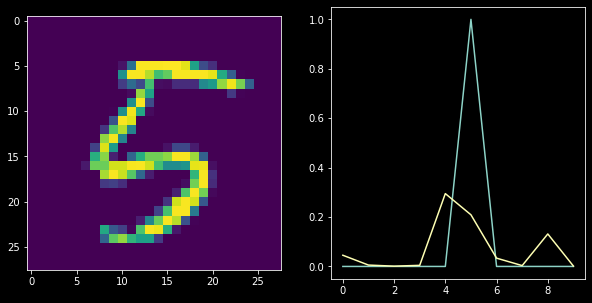

In [17]:
c = 0
counter = 0
error_to_find = 0.1
while c < error_to_find or not counter:
    x, y = ds_test.iloc[rnd.randint(0, len(ds_test)-1)]
    pred = forward(model, x)[1][-1]
    c = sum((pred - y)**2)
    counter += 1
(fig, [ax1, ax2]) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(x.reshape(28, -1))
ax2.plot(y)
ax2.plot(pred)
print(f"To find image with error {error_to_find}, {counter} steps needed.")